Reference for this notebook: [Fine Tunning Bert For Sentiment Analysis](https://skimai.com/fine-tuning-bert-for-sentiment-analysis/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -q transformers

In [ ]:
import pandas as pd
import time
import numpy as np
import random
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from nltk import word_tokenize, WordNetLemmatizer
import sklearn.metrics as metrics
import pickle
from torch.utils.data import TensorDataset, random_split #creating tensor datasets and DataLoaders

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#we add GPU so the code can run faster
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

#GPU is available
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# GPU not available
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#BERT tokenizer
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


**PART 1 - One Time Run**

Dataset is transform and saved as input for BERT

**Read the Dataset**

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/X_train_all.csv')
test =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/X_test_all.csv')
y_train = pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_train_all.csv')
y_test =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_test_all.csv')

In [ ]:
#creating a column with words length 50 to be used because bert will lematize the words itsel
#and we should make sure it is using all the same words

train['pad_50_sen'] = train['clean_review'].astype(str).apply(lambda x : ' '.join(x.strip().split(" ")[:50]))
test['pad_50_sen'] = test['clean_review'].apply(lambda x : ' '.join(x.strip().split(" ")[:50]))

In [ ]:
#in order to have the same training test as other neural networks, we get the validation set from train_df
train, val, y_train, y_val = train_test_split(train, y_train, test_size=0.1, random_state=42)

In [ ]:
# Get the lists of reviews and their labels.
#we use the reviews which are cutted to the number of 50 words
#so we make sure that all classfiers are trained and tested using the same sentences
train_x = train.pad_50_sen.values
train_y = y_train.rate.values

val_x = val.pad_50_sen.values
val_y = y_val.rate.values

test_x = test.pad_50_sen.values
test_y = y_test.rate.values

**Transform the dataset**

In [ ]:
#SENTENCE TOKENIZATION
def get_inputs_ids_mask(reviews, labels):
  %%time
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in reviews:
      # `encode_plus will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the [CLS] token to the start.
      #   (3) Append the [SEP] token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 100, #we set the max length to 100 considering that bert applies word-piece tokenization
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                          truncation = True
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [ ]:
train_ii, train_masks, train_labels = get_inputs_ids_mask(train_x, train_y)
val_ii, val_masks, val_labels = get_inputs_ids_mask(val_x, val_y)
test_ii, test_masks, test_labels = get_inputs_ids_mask(test_x, test_y)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [ ]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_ii, train_masks, train_labels)
val_dataset = TensorDataset(val_ii, val_masks, val_labels)
test_dataset = TensorDataset(test_ii, test_masks, test_labels)

In [ ]:
# Save the tensorDatasets: --test dataset will be needed later for prediction part
torch.save(train_dataset, '/content/drive/MyDrive/MasterThesis/Dataset/train_tensor_ds')
torch.save(val_dataset, '/content/drive/MyDrive/MasterThesis/Dataset/val_tensor_ds')
torch.save(test_dataset, '/content/drive/MyDrive/MasterThesis/Dataset/test_tensor_ds')

**PART 2 - Train and save the model**

In [ ]:
#load tensor datset
train_dataset = torch.load('/content/drive/MyDrive/MasterThesis/Dataset/train_tensor_ds')
val_dataset = torch.load('/content/drive/MyDrive/MasterThesis/Dataset/val_tensor_ds')
test_dataset = torch.load('/content/drive/MyDrive/MasterThesis/Dataset/test_tensor_ds')

In [ ]:
#an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Specifying batch size for the DataLoader
# The the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training set
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

# Create the DataLoaders for our validation set
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
)

**Initializing BERT**

In [ ]:
from transformers import BertForSequenceClassification, AdamW
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # 12-layer BERT model with an uncased vocab.
    num_labels = 2, # we have two classes: positive and negative  
    output_attentions = False, # return attentions weights.
    output_hidden_states = False, # return hidden-states.
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup
# authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps = [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Helper function for formatting elapsed times as hh:mm:ss
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.cuda.empty_cache()

**Training and Save the Model - One Time Run**

In [ ]:
#TRAINING
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. 
        model.zero_grad()        
         

      # Perform a forward pass (evaluate the model on this training batch).
        loss_logits_ = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            labels=b_labels)

        loss = loss_logits_[0]
        logits_t = loss_logits_[1]

        logits_t_cpu = logits_t.detach().cpu().numpy()
        train_pred = np.argmax(logits_t_cpu, axis=1).flatten()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss_logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = loss_logits[0]
            logits_val = loss_logits[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits_val = logits_val.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        val_pred = np.argmax(logits_val, axis=1).flatten()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits_val, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:20.
  Batch    80  of    460.    Elapsed: 0:00:40.
  Batch   120  of    460.    Elapsed: 0:01:00.
  Batch   160  of    460.    Elapsed: 0:01:20.
  Batch   200  of    460.    Elapsed: 0:01:41.
  Batch   240  of    460.    Elapsed: 0:02:02.
  Batch   280  of    460.    Elapsed: 0:02:23.
  Batch   320  of    460.    Elapsed: 0:02:44.
  Batch   360  of    460.    Elapsed: 0:03:05.
  Batch   400  of    460.    Elapsed: 0:03:27.
  Batch   440  of    460.    Elapsed: 0:03:48.

  Average training loss: 0.28
  Training epcoh took: 0:03:58

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.21
  Validation took: 0:00:10

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    460.    Elapsed: 0:00:21.
  Batch    80  of    460.    Elapsed: 0:00:42.
  Batch   120  of    460.    Elapsed: 0:01:04.
  Batch   160  of    460.    Elapsed: 0:01:25.
  Batch   200  of    460.    Elapsed: 0:01:46.
  Batch  

In [ ]:
#Saving the model
tokenizer.save_pretrained('/content/drive/MyDrive/MasterThesis/Dataset/tokenizer_bert_1')
torch.save(model, '/content/drive/MyDrive/MasterThesis/BERT/bert_1')

In [ ]:
#Summary of training process

pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.21,0.91,0:03:58,0:00:10
2,0.16,0.23,0.92,0:04:05,0:00:10
3,0.09,0.29,0.92,0:04:03,0:00:10


In [ ]:
df_stats[['Training Loss', 'Valid. Loss', 'Valid. Accur.']].mean().apply(lambda x: round(x, 2))

Training Loss    0.18
Valid. Loss      0.24
Valid. Accur.    0.92
dtype: float64

**Part 3 - Test**

In [ ]:
#Initializing the model
from transformers import BertTokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

from transformers import BertForSequenceClassification, AdamW, BertConfig
device = torch.device("cuda")
model = torch.load('/content/drive/MyDrive/MasterThesis/BERT/bert_1', map_location="cuda:0")  # Choose whatever GPU device number you want
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Save the tensorDatasets
test_dataset = torch.load('/content/drive/MyDrive/MasterThesis/Dataset/test_tensor_ds')

prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
#accuracy for testing
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from torch.nn import functional as F
# a function tu evaluate a model
def evaluate_model(model, dataloader, GPU_device):
  # Put model in evaluation mode
  model.eval()
  
  # Tracking variables 
  predictions, true_labels = [], []

  # Predict 
  for batch in dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits= logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
  

  loss_cross = F.cross_entropy(outputs.logits, b_labels)
  print('loss is: ' + str(loss_cross))
  print('    DONE.')
  return predictions, true_labels, loss_cross

In [ ]:
#we can create a train_dataloader too and check the results, but I do not thin it is neccessary right now
pred_test, true_test, loss_test = evaluate_model(model, prediction_dataloader, device) #as logit

loss is: tensor(0.3192, device='cuda:0')
    DONE.


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#test
total_eval_accuracy = 0
for i in range(len(pred_test)):
  total_eval_accuracy += flat_accuracy(pred_test[i], true_test[i])
#print(total_eval_accuracy)
#test
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("Accuracy: {0:.2f}".format(avg_val_accuracy))
#test
pred_flat = np.argmax(pred_test[0], axis=1).flatten()
labels_flat = true_test[0].flatten()
tot_ev_acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
#print(tot_ev_acc)

Accuracy: 0.93


In [ ]:
#flat predictions
import itertools
test =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/X_test_all.csv')
y_pred =   []
for review in test.clean_review:
  encoded = tokenizer.encode_plus(str(review), return_token_type_ids=False, return_tensors = 'pt', truncation = True)
  encoded_ids = encoded['input_ids'].to(device)
  enconded_attention = encoded['attention_mask'].to(device)
  with torch.no_grad(): 
    output = model(encoded_ids, attention_mask=enconded_attention)[0]
    output = output.detach().cpu().numpy()
    pred_flat = np.argmax(output, axis=1).flatten()
    y_pred.append(pred_flat)
    
y_pred = (list(itertools.chain.from_iterable(y_pred)))

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_1_pred', 'wb') as f:
    pickle.dump(y_pred, f)    

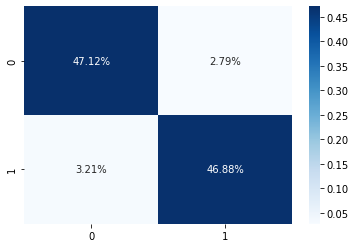

In [ ]:
y_test = (pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/y_test_all.csv')).rate

from sklearn.metrics import confusion_matrix
import seaborn as sn
cf_matrix = confusion_matrix(y_test, y_pred)
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


In [ ]:
print (metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2038
           1       0.94      0.94      0.94      2045

    accuracy                           0.94      4083
   macro avg       0.94      0.94      0.94      4083
weighted avg       0.94      0.94      0.94      4083



In [ ]:
#predictions as propabilities
import itertools
test =  pd.read_csv('/content/drive/MyDrive/MasterThesis/Dataset/X_test_all.csv')
y_pred =   []
for review in test.clean_review:
  encoded = tokenizer.encode_plus(str(review), return_token_type_ids=False, return_tensors = 'pt', truncation = True)
  encoded_ids = encoded['input_ids'].to(device)
  enconded_attention = encoded['attention_mask'].to(device)
  with torch.no_grad(): 
    output = model(encoded_ids, attention_mask=enconded_attention)[0]
    tensor_logits = output
    probas = F.softmax(tensor_logits, dim=-1).cpu().detach().numpy()
    y_pred.append(probas)
    
y_pred = (list(itertools.chain.from_iterable(y_pred)))

In [ ]:
with open('/content/drive/MyDrive/MasterThesis/Dataset/bert_1_pred_propab', 'wb') as f:
    pickle.dump(y_pred, f)    